In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
import statsmodels.api as sm

# L1正則化とスパース性

In [2]:
n = 30       # データ数
d = 50       # パラメータの次元
s = 10       # パラメータの非ゼロ要素数
# データ生成
beta = np.r_[np.ones(s),np.zeros(d-s)]
X = np.random.randn(n,d)
y = np.dot(X,beta) + np.random.normal(scale=0.01,size=n)
la = sm.OLS(y,X).fit_regularized(alpha=0.1, L1_wt=1)  # ラッソ
ri = sm.OLS(y,X).fit_regularized(alpha=0.1, L1_wt=0)  # リッジ

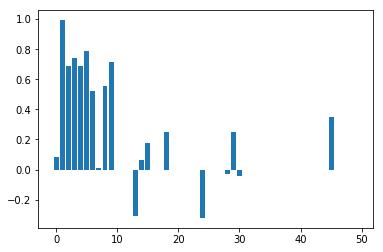

In [3]:
# プロット：ラッソ
plt.bar(np.arange(d),la.params); plt.show()

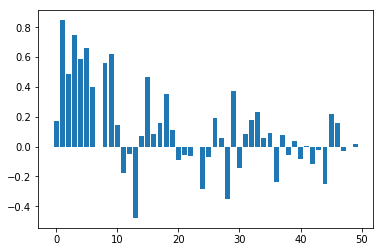

In [4]:
# プロット：リッジ
plt.bar(np.arange(d),ri.params); plt.show()

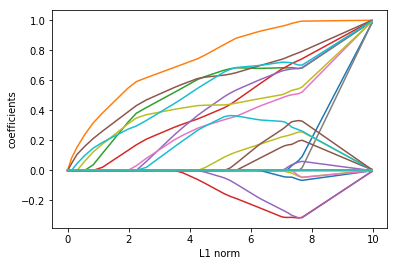

In [5]:
from sklearn import linear_model           # lasso_path を使う
# ラッソの正則化パスの計算
alphas, coef_path, _ = linear_model.lasso_path(X, y)
# 正則化パラメータ毎に回帰係数のL1ノルムを計算
coefL1 = np.sum(np.abs(coef_path), axis=0)  
# プロット
plt.xlabel('L1 norm')
plt.ylabel('coefficients')
for i in np.arange(d):
    plt.plot(coefL1, coef_path[i,:])
plt.show()

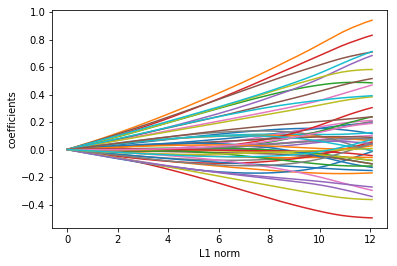

In [6]:
# リッジの正則化パスの計算
alphas = np.logspace(np.log10(10**-3),np.log10(10**3),200) # 正則化パラメータ
coefs = []
for a in alphas:
    ri = sm.OLS(y,X).fit_regularized(alpha=a, L1_wt=0)     # リッジ回帰
    coefs.append(ri.params)
coef_path = np.array(coefs).T
# 各正則化パラメータにおける回帰係数のL1ノルムを計算
coefL1 = np.sum(np.abs(coef_path),axis=0)
# プロット
plt.xlabel('L1 norm')
plt.ylabel('coefficients')
for i in np.arange(d):
    plt.plot(coefL1,coef_path[i,:])
plt.show()

# エラスティック・ネット

In [7]:
n = 100; d = 200; s = 30     # 設定：データ数，次元，非ゼロ係数の数
beta = np.r_[np.ones(s),np.zeros(d-s)]             # 真のパラメータ
# データ生成
X = np.random.randn(n,d)
y = np.dot(X,beta) + np.random.normal(scale=0.01,size=n)

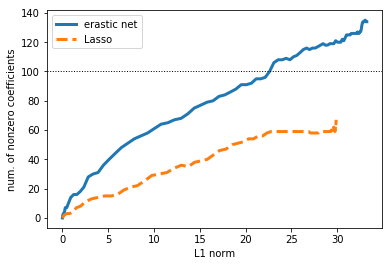

In [8]:
# エラスティック・ネットの正則化パス：w=0.1
_,coef_path,_ = linear_model.enet_path(X,y,l1_ratio=0.3)
coefL1 = np.sum(np.abs(coef_path),axis=0)         # 回帰係数のL1ノルム
nonzeros = np.sum(coef_path!=0,axis=0)            # 非ゼロ要素数

# プロット：エラスティック・ネットの正則化パス
plt.plot(coefL1, nonzeros,linestyle='solid',lw=3, label='erastic net')

# ラッソの正則化パスの計算
_,coef_path,_ = linear_model.lasso_path(X,y)
coefL1 = np.sum(np.abs(coef_path),axis=0)        # 回帰係数のL1ノルム
nonzeros = np.sum(coef_path!=0,axis=0)           # 非ゼロ要素数

# プロット：ラッソの正則化パス
plt.plot(coefL1, nonzeros,linestyle='dashed',lw=3,label='Lasso') 

# 設定：非ゼロ要素数のプロット
plt.xlabel('L1 norm')
plt.ylabel('num. of nonzero coefficients')
plt.axhline(y=n,c='black',linestyle=':',lw=1) # 高さ n の水平線をプロット
plt.legend()
plt.show()

# スパース・ロジスティック回帰

In [9]:
from sklearn.linear_model import LogisticRegression
n = 100; d = 200; s = 30  # 設定：データ数，次元，非ゼロ要素数
# パラメータ設定
beta = np.r_[np.ones(s),np.zeros(d-s)]      # 真のパラメータ
# データ生成
X = np.random.randn(n,d)
y = (np.dot(X,beta) + np.random.normal(scale=0.001,size=n) >= 0)
alpha = 1  # 正則化パラメータ: 1/C
slr = LogisticRegression(penalty='l1',C=1/alpha) # L1正則化
slr.fit(X,y)
rlr = LogisticRegression(penalty='l2',C=1/alpha) # L2正則化
rlr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

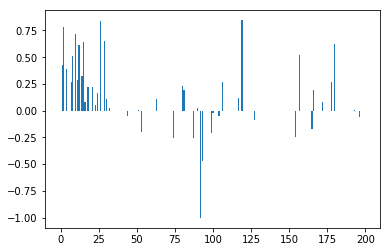

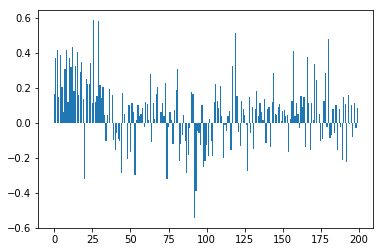

In [10]:
# 推定された回帰係数のプロット
plt.bar(np.arange(d),slr.coef_[0]); plt.show()  # L1正則化
plt.bar(np.arange(d),rlr.coef_[0]); plt.show()  # L2正則化

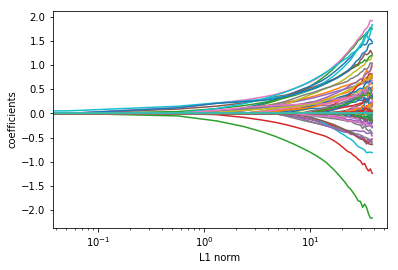

In [11]:
# スパース・ロジスティック回帰の正則化パス
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import l1_min_c        # l1_min_cを使う
slr = LogisticRegression(penalty='l1')
# 正則化パラメータの範囲を設定
cs = l1_min_c(X, y, loss='log') * np.logspace(-2, 3)
coefs = []  
for c in cs:      
    slr.set_params(C=c).fit(X,y)   # 各Cでの回帰係数を推定
    coefs.append(slr.coef_[0])
coef_path = np.array(coefs).T     
coefL1 = np.sum(np.abs(coef_path),axis=0)  # 回帰係数のL1ノルム
# プロット準備
plt.xlabel('L1 norm'); plt.xscale('log'); plt.ylabel('coefficients')
# 回帰係数毎にプロット
for i in np.arange(d):
    plt.plot(coefL1,coef_path[i,:])
plt.show()

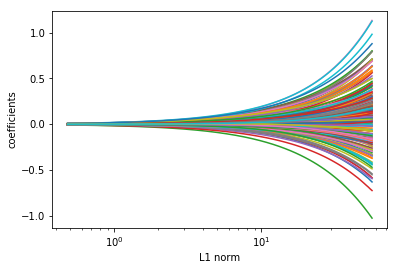

In [12]:
# L2正則化ロジスティック回帰の正則化パス
slr = LogisticRegression(penalty='l2')
# 正則化パラメータの範囲を設定
cs = l1_min_c(X, y, loss='log') * np.logspace(-2, 3)
coefs = []  
for c in cs:      
    slr.set_params(C=c).fit(X,y)   # 各Cでの回帰係数を推定
    coefs.append(slr.coef_[0])
coef_path = np.array(coefs).T     
coefL1 = np.sum(np.abs(coef_path),axis=0)  # 回帰係数のL1ノルム
# プロット準備
plt.xlabel('L1 norm'); plt.xscale('log'); plt.ylabel('coefficients')
# 回帰係数毎にプロット
for i in np.arange(d):
    plt.plot(coefL1,coef_path[i,:])
plt.show()

# 条件付き独立性とスパース学習

In [35]:
from sklearn.covariance import GraphLassoCV
from sklearn import datasets  
d = 10; n = 100   # 次元，サンプル数
# スパース正定値行列の生成：非対角要素が0になる確率は0.8
P = datasets.make_sparse_spd_matrix(d,alpha=0.8)   

In [36]:
# Pの逆行列を分散共分散行列にもつ多次元正規分布からデータ生成
cov = np.linalg.inv(P)                             
X = np.random.multivariate_normal(np.zeros(d), cov, size=n)
# スパース精度行列の推定．正則化パラメータは交差検証法で選択
gl = GraphLassoCV()         
gl.fit(X)                                   # 推定

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

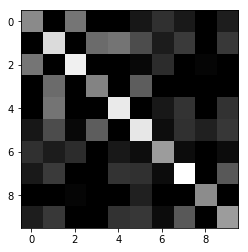

In [38]:
plt.imshow(np.abs(P),'gray'); 
plt.show()                    # 真の精度行列

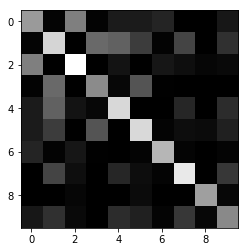

In [39]:
plt.imshow(np.abs(gl.precision_),'gray')
plt.show() # 推定結果

選択された alpha:  0.055336700649


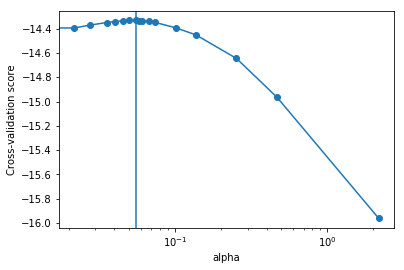

In [41]:
# 交差検証法の結果をプロット
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')
plt.xscale('log')
plt.plot(gl.cv_alphas_,np.mean(gl.grid_scores_, axis=1),'o-')
plt.axvline(gl.alpha_)
print('選択された alpha: ', gl.alpha_)      # 選択されたalphaの値
#plt.show()
plt.savefig('chap-sparse-gralasso-regpath.pdf')

# 辞書学習

In [18]:
from PIL import Image           # Imageを使う
# 辞書学習関連ツール
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
# 画像ファイル名
imfiles = ['boat.png','goldhill.png','barbara512.bmp','pepper512.bmp']
patch_size = (8,8)              # パッチサイズ
imgs = np.empty((0,np.prod(patch_size)))
for f in imfiles:               # 各画像からパッチを切り出しデータ行列を生成
    im = np.asarray(Image.open('data/'+f))
    imp = extract_patches_2d(im, patch_size)
    imgs = np.append(imgs, imp.reshape(imp.shape[0],-1), axis=0)
imgs.shape

(1020100, 64)

In [19]:
imgs

array([[ 127.,  123.,  125., ...,  123.,  126.,  126.],
       [ 123.,  125.,  120., ...,  126.,  126.,  128.],
       [ 125.,  120.,  126., ...,  126.,  128.,  133.],
       ..., 
       [ 189.,  194.,  173., ...,  189.,  188.,  184.],
       [ 194.,  173.,  173., ...,  188.,  184.,  192.],
       [ 173.,  173.,  187., ...,  184.,  192.,  196.]])

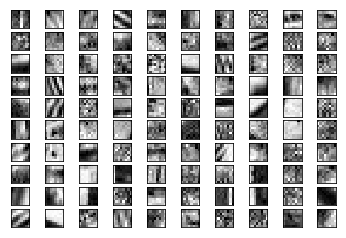

In [20]:
# 元画像の画像パッチ(imgs)をランダムに100枚選ぶ
pi = imgs[np.random.choice(np.arange(imgs.shape[0]),100,replace=False),:]
for i, comp in enumerate(pi[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size),              # 行列をプロット
               cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(()); plt.yticks(())
plt.show()

In [21]:
# 辞書を学習
DL = MiniBatchDictionaryLearning(n_components=100, alpha=100, n_iter=3000)
DT = DL.fit(imgs).components_                     # Dの転置行列

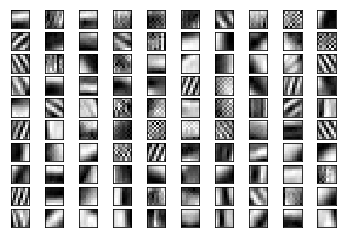

In [22]:
# 辞書をプロット
for i, m in enumerate(DT[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(m.reshape(patch_size), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(()); plt.yticks(())
plt.show()

In [42]:
# 辞書学習による画像のノイズ除去 1
# 元画像
image_true  = np.asarray(Image.open('data/lenna.png'))
h = image_true.shape[0]; w = image_true.shape[1]
noisemat = 50 * np.random.randn(h,w) * np.random.choice([0,1],size=w*h,p=[0.5,0.5]).reshape(h,w)
# ノイズを付加した画像
image_noise = np.clip(np.round(image_true + noisemat),0,255)
# 画像パッチの切り出し
data = extract_patches_2d(image_noise, patch_size)
data = data.reshape(data.shape[0], -1)
# スパース表現の構成
UT = DL.transform(data)   # U=(u_1,...,u_n) の転置
# 画像パッチの再構成
reconst_patch = np.dot(UT, DT).reshape(len(data), *patch_size)  
# 画像の再構成
image_denoise = reconstruct_from_patches_2d(reconst_patch, (h,w))

プロット：元画像


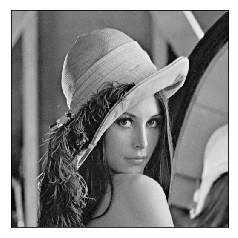

In [43]:
print('プロット：元画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,color='white')
plt.imshow(image_true,cmap='gray')
plt.show()

プロット：ノイズを付加した画像


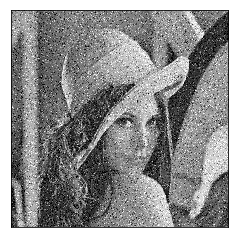

In [48]:
print('プロット：ノイズを付加した画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,color='white')
plt.imshow(image_noise,cmap='gray')
plt.show()

プロット：ノイズを除去した画像


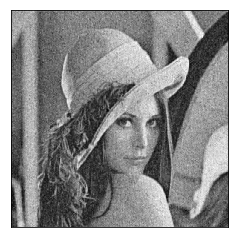

In [49]:
print('プロット：ノイズを除去した画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,color='white')
plt.imshow(np.asarray(image_denoise),cmap='gray')
plt.show()

In [29]:
# 辞書学習による画像のノイズ除去 2
# 元画像
img = Image.open('data/shrine512.jpg')
image_true  = np.asarray(img.convert('L'))        # グレイスケールに変換
h = image_true.shape[0]; w = image_true.shape[1]
noisemat = 50 * np.random.randn(h,w) * np.random.choice([0,1],size=w*h,p=[0.5,0.5]).reshape(h,w)
# ノイズを付加した画像
image_noise = np.clip(np.round(image_true + noisemat),0,255)
# 画像パッチの切り出し
data = extract_patches_2d(image_noise, patch_size)
data = data.reshape(data.shape[0], -1)
# スパース表現の構成
UT = DL.transform(data)   # U=(u1,...,un) の転置
# 画像パッチの再構成
reconst_patch = np.dot(UT, DT).reshape(len(data), *patch_size)  
# 画像の再構成
image_denoise = reconstruct_from_patches_2d(reconst_patch, (h,w))

プロット：元画像


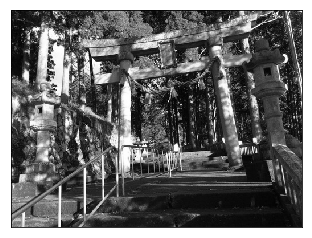

In [39]:
print('プロット：元画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False); plt.tick_params(color='white')
plt.imshow(image_true,cmap='gray')
plt.show()

プロット：ノイズを付加した画像


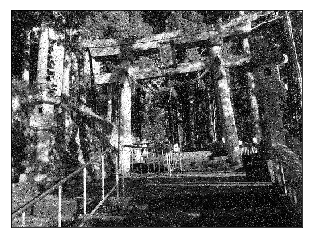

In [40]:
print('プロット：ノイズを付加した画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False); plt.tick_params(color='white')
plt.imshow(image_noise,cmap='gray')
plt.show()

プロット：ノイズを除去した画像


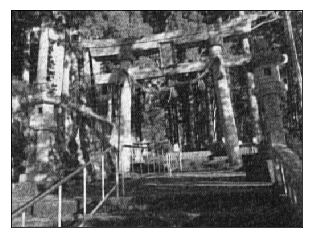

In [41]:
print('プロット：ノイズを除去した画像')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False); plt.tick_params(color='white')
plt.imshow(np.asarray(image_denoise),cmap='gray')
plt.show()